# Skin Cancer Lesion Classification
Source: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

## Import libraries

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import shutil
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

## Load HAM10000 dataset
Read files using file name from the csv and add corresponding image in a pandas dataframe along with labels.

In [ ]:
skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

Read images based on image ID from the CSV file. This is the safest way to read images as it ensures the right image is read for the right ID

In [ ]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

Define the path and add as a new column

In [ ]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)

Use the path to read images

In [ ]:
SIZE=32

skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

print(skin_df['dx'].value_counts())

Plotting

In [ ]:
n_samples = 5  # number of samples for plotting

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

## Reorganize data into subfolders based on their labels

Dump all images into a folder and specify the path

In [ ]:
data_dir = os.getcwd() + "/data/all_images/"

Path to destination directory where we want subfolders

In [ ]:
dest_dir = os.getcwd() + "/data/reorganized/"

Read the csv file containing image names and corresponding labels

In [ ]:
skin_df2 = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

label=skin_df2['dx'].unique().tolist()  #Extract labels into a list
label_images = []

Copy images to new folders

In [ ]:
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df2[skin_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]    

Use keras flow_from_dir to read images with  folder names as labels

In [11]:
# Define datagen. Here we can define any transformations we want to apply to images
datagen = ImageDataGenerator()

In [12]:
# Define training directory that contains subfolders
train_dir = os.getcwd() + "/data/reorganized/"

#Use flow_from_directory
train_data_keras = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=16,  #16 images at a time
                                         target_size=(32,32))  #Resize images

Found 10015 images belonging to 7 classes.


Check images for a single batch

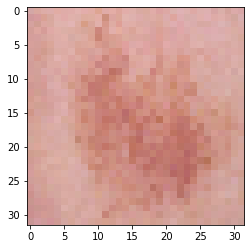

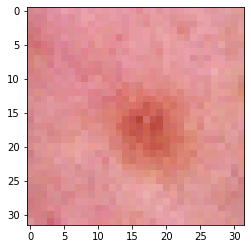

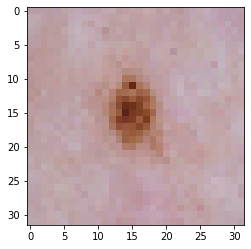

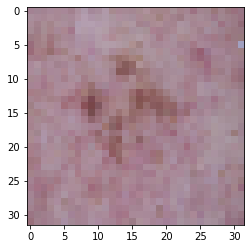

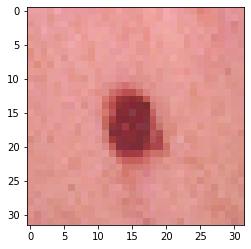

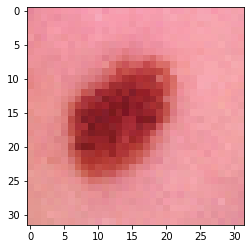

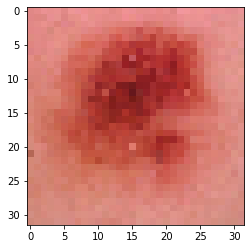

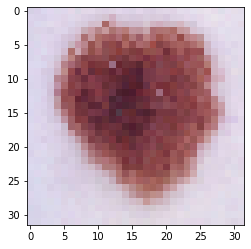

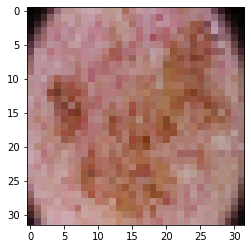

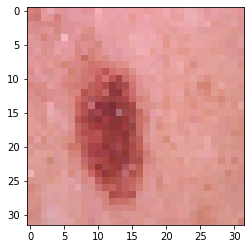

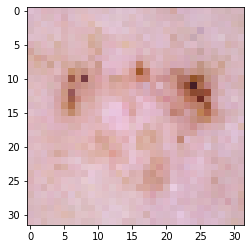

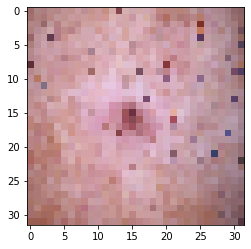

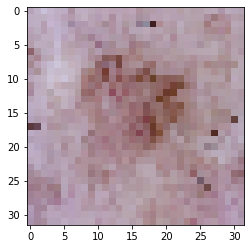

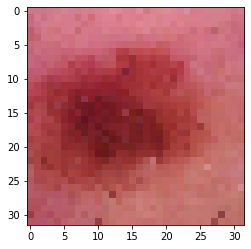

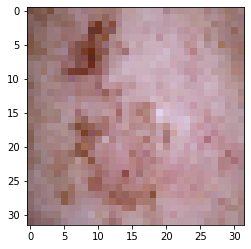

In [13]:
x, y = next(train_data_keras)

for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()

## With Autokeras build a model and save it for later classification task

### Label encoding to numeric values from text

In [14]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age      sex  \
971   HAM_0000948  ISIC_0033631  bkl  consensus   NaN  unknown   
606   HAM_0005865  ISIC_0031522  bkl      histo  70.0     male   
7198  HAM_0005116  ISIC_0032953   nv      histo   5.0   female   
695   HAM_0003015  ISIC_0025083  bkl      histo  55.0     male   
787   HAM_0002042  ISIC_0028294  bkl   confocal  75.0   female   
6936  HAM_0004869  ISIC_0025370   nv      histo  15.0   female   
6292  HAM_0004162  ISIC_0031944   nv  follow_up  65.0     male   
9323  HAM_0006553  ISIC_0026942   nv  consensus  20.0   female   
7480  HAM_0007306  ISIC_0026810   nv      histo  30.0     male   
8886  HAM_0004518  ISIC_0024578   nv      histo  35.0   female   

         localization                                               path  \
971           unknown  data/HAM10000\HAM10000_images_part_2\ISIC_0033...   
606             chest  data/HAM10000\HAM10000_images_part_2\ISIC_0031.

### Data distribution visualization

C:\Users\eraym\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


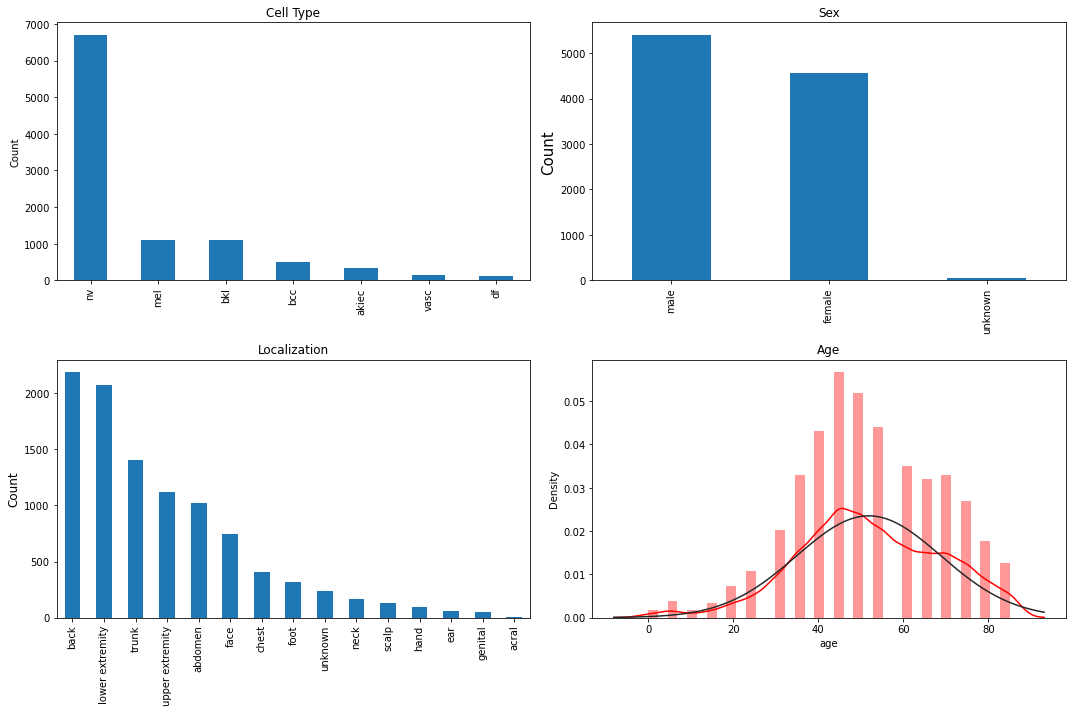

In [15]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [16]:
# Distribution of data into various classes 
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


### Balancing data

In [17]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])


Now time to read images based on image ID from the CSV file. This is the safest way to read images as it ensures the right image is read for the right ID

In [18]:
print(skin_df_balanced['label'].value_counts())

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


Plotting

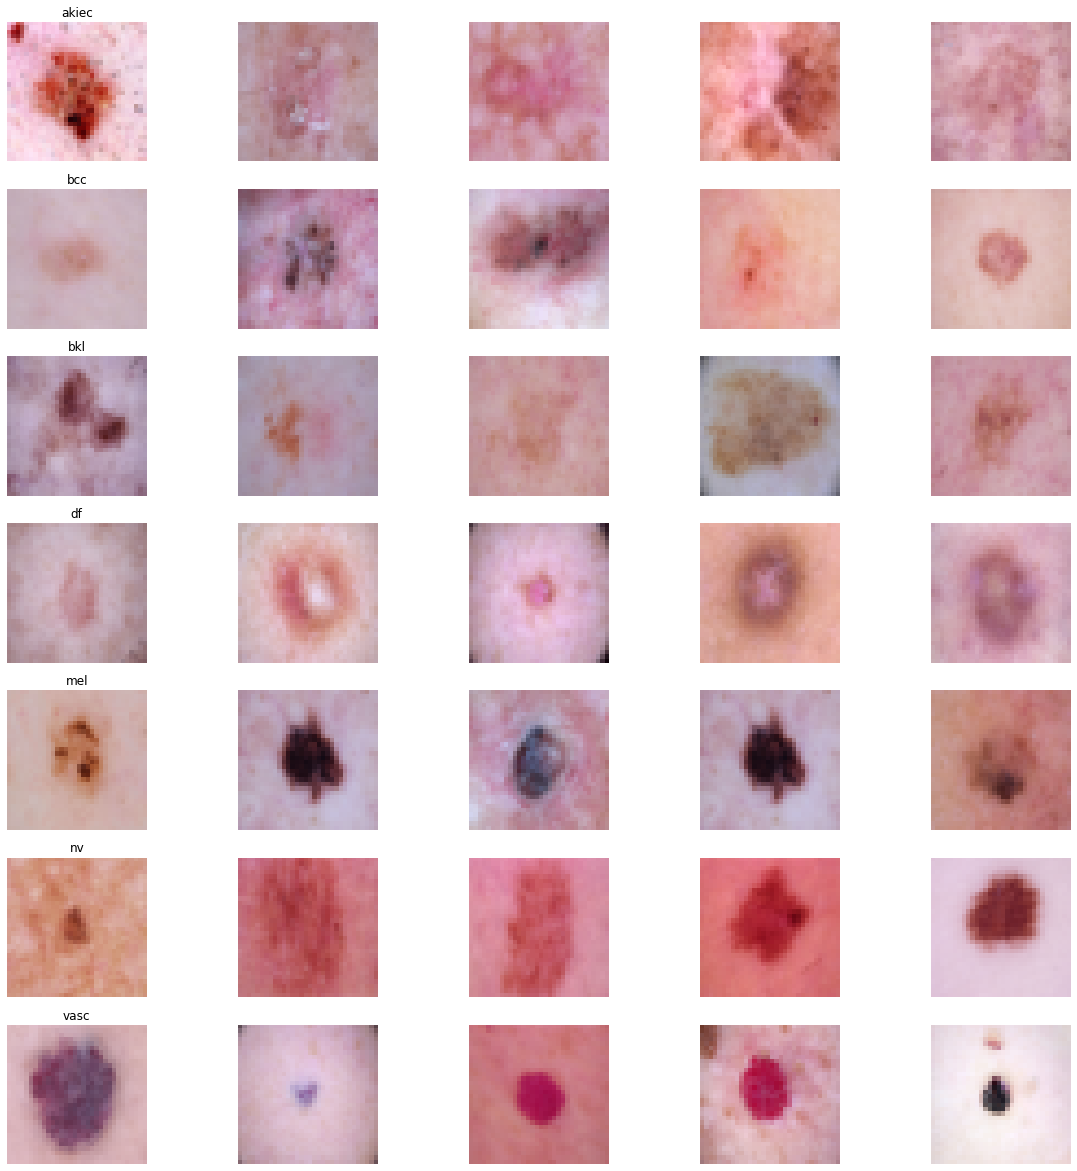

In [19]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

### Convert dataframe column of images into numpy array

In [20]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.

Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

### Splitting data

In [21]:
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

#Further split data into smaller size to get a small test dataset. 
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)

### Define classifier for autokeras. Here we check 5 different models, each model 10 epochs

In [ ]:
clf = ak.ImageClassifier(max_trials=5) #MaxTrials - max. number of keras models to try
clf.fit(x_train_auto, y_train_auto, epochs=10)

### Evaluation and Saving the Model

In [ ]:
#Evaluate the classifier on test data
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

# get the final best performing model
model = clf.export_model()
print(model.summary())

#Save the model
model.save('ham_model.h5')

score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])

## Model Building

In [24]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

### Training

In [25]:
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
11/11 - 9s - loss: 1.9879 - acc: 0.1314 - val_loss: 1.9506 - val_acc: 0.1690 - 9s/epoch - 774ms/step
Epoch 2/50
11/11 - 6s - loss: 1.9737 - acc: 0.1257 - val_loss: 1.9465 - val_acc: 0.1417 - 6s/epoch - 584ms/step
Epoch 3/50
11/11 - 7s - loss: 1.9517 - acc: 0.1657 - val_loss: 1.9457 - val_acc: 0.1420 - 7s/epoch - 603ms/step
Epoch 4/50
11/11 - 7s - loss: 1.9468 - acc: 0.1200 - val_loss: 1.9465 - val_acc: 0.1555 - 7s/epoch - 645ms/step
Epoch 5/50
11/11 - 7s - loss: 1.9464 - acc: 0.1486 - val_loss: 1.9451 - val_acc: 0.1522 - 7s/epoch - 643ms/step
Epoch 6/50
11/11 - 7s - loss: 1.9385 - acc: 0.2000 - val_loss: 1.9392 - val_acc: 0.2220 - 7s/epoch - 633ms/step
Epoch 7/50
11/11 - 7s - loss: 1.9353 - acc: 0.1371 - val_loss: 1.9318 - val_acc: 0.2301 - 7s/epoch - 614ms/step
Epoch 8/50
11/11 - 7s - loss: 1.9241 - acc: 0.1886 - val_loss: 1.9143 - val_acc: 0.2138 - 7s/epoch - 639ms/step
Epoch 9/50
11/11 - 7s - loss: 1.9004 - acc: 0.2000 - val_loss: 1.9265 - val_acc: 0.1468 - 7s/epoch - 620

### Plot the training and validation accuracy and loss at each epoch

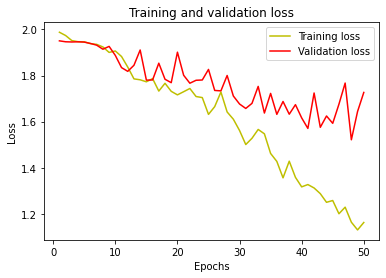

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

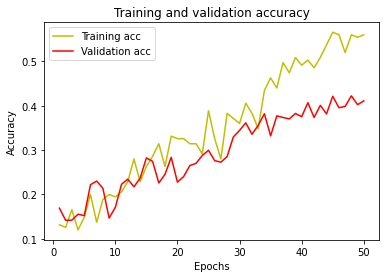

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Prediction

104/104 [==============================] - 6s 58ms/step


<AxesSubplot:>

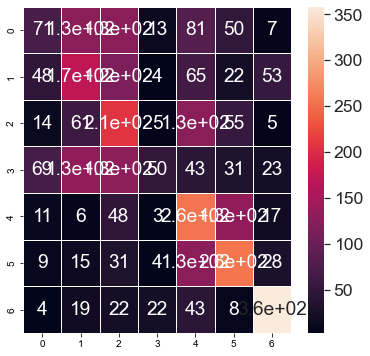

In [28]:
y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

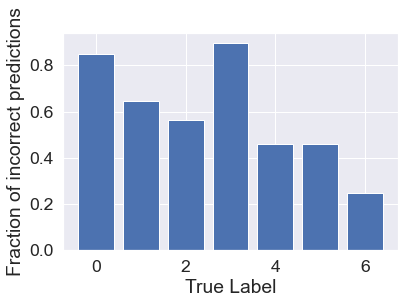

In [29]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')